In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate,KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [216]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv',index_col='building_id')

In [217]:
set_train = train_values.merge(train_labels)
set_train.drop( columns=["building_id"], inplace=True)
set_train = set_train[set_train['count_floors_pre_eq'] <= 6]

In [245]:
set_train.head(20)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,resistance,position_j,position_o,position_s,position_t,owner_a,owner_r,owner_v,owner_w,base_condition
0,6,487,12198,2,30,6,5,t,r,0.701689,...,0.70,0,0,0,1,0,0,1,0,1.672970
1,8,900,2812,2,10,8,7,o,r,0.701689,...,0.50,0,0,1,0,0,0,1,0,0.873104
2,21,363,8973,2,10,5,5,t,r,0.701689,...,0.50,0,0,0,1,0,0,1,0,1.672970
3,22,418,10694,2,10,6,5,t,r,0.701689,...,0.90,0,0,1,0,0,0,1,0,1.672970
4,11,131,1488,3,30,8,9,t,r,0.701689,...,0.20,0,0,1,0,0,0,1,0,1.672970
5,8,558,6089,2,10,9,5,t,r,0.701689,...,0.50,0,0,1,0,0,0,1,0,1.672970
6,9,475,12066,2,25,3,4,n,r,0.701689,...,0.50,0,0,1,0,0,0,1,0,0.977537
7,20,323,12236,2,0,8,6,t,w,0.236322,...,1.15,0,0,1,0,0,0,1,0,0.889787
8,0,757,7219,2,15,8,6,t,r,0.236322,...,0.80,0,0,1,0,0,0,1,0,1.672970
9,26,886,994,1,0,13,4,t,i,0.701689,...,0.85,0,0,1,0,0,0,1,0,0.872271


In [219]:
def encoding(values, columnData, setDatos):
    df = pd.DataFrame()
    column = columnData
    if(setDatos=='set_train'):
        df[values] = pd.get_dummies(set_train[column])
    else:
        df[values] = pd.get_dummies(test_values[column])
    df['sumatory'] = 0
    for i in range(len(values)):
        df['sumatory'] += df[values[i]] * df[values[i]].mean()
    
    return df['sumatory']

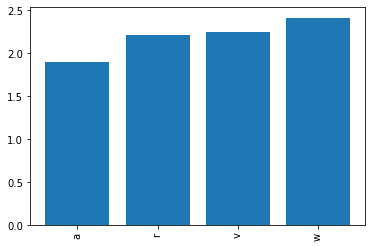

In [220]:
owner = pd.DataFrame()
owner[['a', 'r', 'v', 'w']]= pd.get_dummies(set_train['legal_ownership_status'])
owner.sum()

owner['damage_grade'] = set_train['damage_grade']
vector_names = ['a', 'r', 'v', 'w']
promedios = []
for x in range(len(vector_names)):
    aux = owner.loc[owner[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios)
plt.xticks(rotation=90)
plt.show()

#count_families = pd.DataFrame()
#count_families[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']] = pd.get_dummies(set_train['count_families'])
#count_families

#count_families['damage_grade'] = set_train['damage_grade']
#vector_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#promedios = []
#for x in range(len(vector_names)):
#    aux = count_families.loc[count_families[vector_names[x]] == 1,:]
#    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

#plt.bar(vector_names, promedios)
#plt.xticks(rotation=90)
#plt.show()

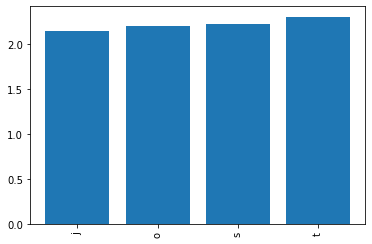

In [221]:
position = pd.DataFrame()
position= pd.get_dummies(set_train['position'])
position.sum()

position['damage_grade'] = set_train['damage_grade']
vector_names = ['j', 'o', 's', 't']
promedios = []
for x in range(len(vector_names)):
    aux = position.loc[position[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios)
plt.xticks(rotation=90)
plt.show()

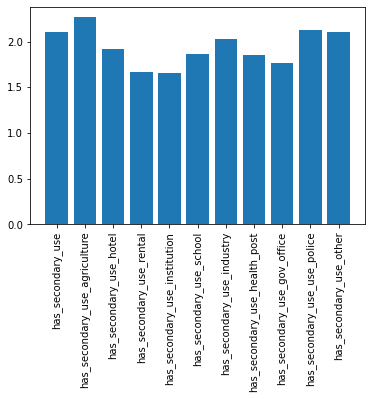

In [222]:
secondary_use = set_train.iloc[:,27:38]
secondary_use['damage_grade'] = set_train['damage_grade']
vector_names = ['has_secondary_use','has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental',
               'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 
               'has_secondary_use_health_post', 'has_secondary_use_gov_office','has_secondary_use_use_police',
               'has_secondary_use_other']
promedios = []
for x in range(len(vector_names)):
    aux = secondary_use.loc[secondary_use[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

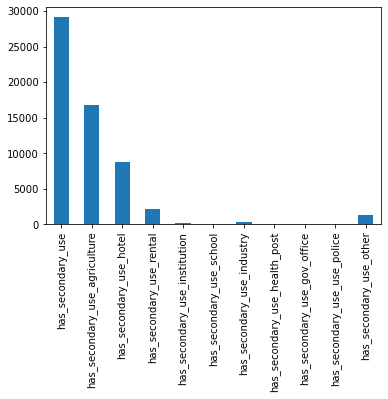

In [223]:
set_train.iloc[:, 27:38].sum().plot.bar()

In [224]:
drop_columns = set_train.columns.values[26:38]
set_train.drop(columns= drop_columns, inplace = True)

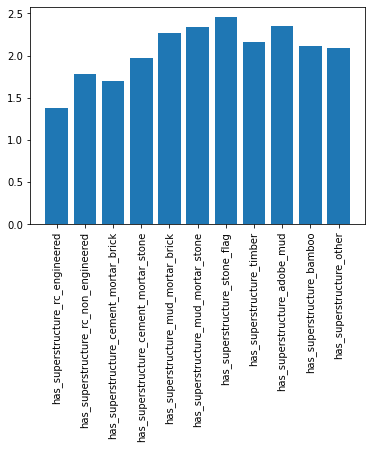

In [225]:
materiales = set_train.iloc[:,14:25]
materiales['damage_grade'] = set_train['damage_grade']
#vector_names = ['has_superstructure_rc_engineered','has_superstructure_cement_mortar_brick', 'has_superstructure_rc_non_engineered',
 #              'has_superstructure_cement_mortar_stone','has_superstructure_other', 'has_superstructure_bamboo',
  #              'has_superstructure_timber', 
   #             'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone',
    #            'has_superstructure_adobe_mud','has_superstructure_stone_flag']

vector_names = ['has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_cement_mortar_brick',
               'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone',
               'has_superstructure_stone_flag', 'has_superstructure_timber', 'has_superstructure_adobe_mud', 
               'has_superstructure_bamboo', 'has_superstructure_other']
promedios = []
for x in range(len(vector_names)):
    aux = materiales.loc[materiales[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names,promedios )
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

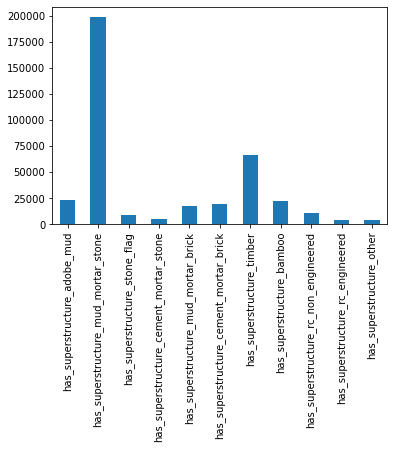

In [226]:
set_train.iloc[:, 14:25].sum().plot.bar()

In [227]:
values = [1, 0.9, 0.85, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
for i in range(11):
    set_train.loc[:, [vector_names[i]]] = set_train.loc[:, [vector_names[i]]]*values[i]

In [228]:
set_train['resistance'] = 0
for x in range(11):
    set_train['resistance'] += set_train[vector_names[x]]
set_train['resistance'].head()

0    0.7
1    0.5
2    0.5
3    0.9
4    0.2
Name: resistance, dtype: float64

In [229]:
set_train[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(set_train['position'])
set_train[['owner_a', 'owner_r', 'owner_v', 'owner_w']]= pd.get_dummies(set_train['legal_ownership_status'])

In [232]:
set_train['base_condition'] = encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'set_train') + encoding(['n', 'o', 't'] , 'land_surface_condition', 'set_train')

In [235]:
set_train['roof_type'] = encoding(['n', 'q', 'x'] , 'roof_type', 'set_train')
set_train['ground_floor_type'] = encoding(['f','m','v','x','z'] , 'ground_floor_type', 'set_train')
set_train['other_floor_type'] = encoding(['j','q','s','x'] , 'other_floor_type', 'set_train')

In [236]:
columnas_seleccionadas = ['age',
                         'geo_level_1_id',
                         'area_percentage',
                         'count_floors_pre_eq',
                         'geo_level_2_id',
                         'height_percentage',
                         'resistance',
                         'roof_type',
                         'ground_floor_type',
                         'other_floor_type',
                         'position_j', 'position_o', 
                         'position_s', 'position_t',
                        #'owner_a', 'owner_r',
                         #'owner_v', 'owner_w',
                         'base_condition',
                          'damage_grade'
                         ]

In [237]:
data_test = test_values

In [238]:
for i in range(11):
    data_test.loc[:, [vector_names[i]]] = test_values.loc[:, [vector_names[i]]]*values[i]
data_test['resistance'] = 0
for x in range(11):
    data_test['resistance'] += data_test[vector_names[x]]

In [239]:
data_test['base_condition'] = encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'test_values') + encoding(['n', 'o', 't'] , 'land_surface_condition', 'test_values')

In [240]:
data_test['roof_type'] = encoding(['n', 'q', 'x'] , 'roof_type', 'test_values')
data_test['ground_floor_type'] = encoding(['f','m','v','x','z'] , 'ground_floor_type', 'test_values')
data_test['other_floor_type'] = encoding(['j','q','s','x'] , 'other_floor_type', 'test_values')

In [241]:
data_test[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(test_values['position'])

In [242]:
#data_test[['owner_a', 'owner_r', 'owner_v', 'owner_w']]= pd.get_dummies(test_values['legal_ownership_status'])

In [243]:
set_train[columnas_seleccionadas].to_csv('data_set.csv', index=False)
data_test.to_csv('data_test.csv')